<font color='red'>**In this notebook, all three embedding models are trained/used to generate neighbourhood specific review embeddings**</font>

# Imports and Global Variables


In [0]:
!pip install pyshp
import pickle, math, random, shapefile, shapely
from shapely.geometry import Polygon, Point

     |████████████████████████████████| 225kB 3.4MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.0-cp36-none-any.whl size=32609 sha256=7adc4b631711eabe923efd9535556ee2b2b23e6f73fb3a122a1e6da301225f51
  Stored in directory: /root/.cache/pip/wheels/a6/0c/de/321b5192ad416b328975a2f0385f72c64db4656501eba7cc1a
Successfully built pyshp


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ast import literal_eval
from collections import defaultdict
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

from scipy import sparse
import spacy

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import string
import random
import torch.utils.data as Data
from torchtext.data import Field, BucketIterator
from torchtext import data

from collections import OrderedDict
import locale
from locale import atof, atoi
locale.setlocale(locale.LC_NUMERIC, '')

'en_US.UTF-8'

In [0]:
!pip install pytorch-ignite

In [0]:
from ignite.handlers import ModelCheckpoint, EarlyStopping, TerminateOnNan
from ignite.engine import Engine, Events
from ignite.metrics import Accuracy, Loss, RunningAverage
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar

In [0]:
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
use_idf = True
max_features = 2**10
pca_components = 2**4
ngram_range = (1,2)
min_df = 100
DRIVE_PATH = Path('/content/drive/My Drive/Thesis2019/')
BUSINESS_DATA_PATH = Path('businesses_final.csv')
NEIGHBOURHOOD_SHAPEFILE_PATH = "neighbourhoods_wgs84/NEIGHBORHOODS_WGS84"
REVIEWS_PATH = ('reviews.csv')
use_cuda = True
years = [2011, 2016]

EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.3

# Data Cleaning and Preprocessing

## TF-IDF Autoencoder

### For Autoencoder training

The datasets loaded in this section are pre-cleaned as described under section 4.2. in the report. 

Reference: https://github.com/alexwolson/uem_projects/blob/master/notebooks/Autoencoders/MAIN_LSA_Neighbourhoods.ipynb

In [0]:
bf_text = pd.read_csv(Path.joinpath(DATA_DIR,'business_text_stripped_all.csv')).dropna()
uf_text = pd.read_csv(Path.joinpath(DATA_DIR,'user_text_stripped_all.csv')).dropna()
nf_text = pd.read_csv(Path.joinpath(DATA_DIR,'neighborhood_text_stripped_all.csv')).dropna()
rf_text = pd.read_csv(Path.joinpath(DATA_DIR,'text_stripped_all.csv')).dropna()

In [0]:
alldocs = list(bf_text['text'].values) + list(uf_text['text'].values) + list(nf_text['text'].values) + list(rf_text['text'].values)

bids = list(bf_text['business'].values)
uids = list(uf_text['user'].values)
nids = list(nf_text['neighborhood'].values)

In [0]:
# Build Count Vector
p = DRIVE_PATH.joinpath('models/vectorizer.pickle')
if p.exists():
    with open(p,'rb') as f:
        vectorizer = pickle.load(f)
    vector_words = vectorizer.transform(alldocs)
else:
    vectorizer = CountVectorizer(strip_accents='ascii', 
                                 stop_words='english', 
                                 ngram_range=ngram_range,
                                 min_df=min_df,
                                 max_features=max_features
                                )
    vector_words = vectorizer.fit_transform(alldocs)
    with open(str(DRIVE_PATH.joinpath('models/vectorizer.pickle')),'wb') as f:
        pickle.dump(vectorizer,f)
words = vectorizer.get_feature_names()

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [0]:
# Store feature/word names
with open(DRIVE_PATH.joinpath('models/words.out'), "w") as txt_file:
    for word in words:
        txt_file.write(word + "\n")

In [0]:
# Build TF-IDF Vector
if use_idf:
    p = DRIVE_PATH.joinpath('models/tfidftransformer.pickle')
    if p.exists():
        with open(p,'rb') as f:
            transformer = pickle.load(f)
    else:
        transformer = TfidfTransformer(use_idf=True)
        transformer = transformer.fit(vector_words)
        with open(p,'wb') as f:
            pickle.dump(transformer,f)

transform = lambda x: normalize(
    transformer.transform(
        vectorizer.transform(
            x.text.values
        )
    ),
    norm='l1',
    axis=1)

In [0]:
bf_vecs = transform(bf_text)
uf_vecs = transform(uf_text)
nf_vecs = transform(nf_text)
rf_vecs = transform(rf_text)

In [0]:
# Create dataset wrapper for PyTorch
class ReviewsVector(Data.Dataset):
    """Reviews Vector dataset."""

    def __init__(self, data):
        """
        Args: 
          data

        """
        self.shape = data.shape
        self.data = torch.tensor(data).type(torch.FloatTensor)
        if use_cuda and torch.cuda.is_available():
          self.data = self.data.cuda()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [0]:
train_vals = sparse.vstack([rf_vecs, bf_vecs, uf_vecs]).todense()
neighborhoods_real = np.array(nf_vecs.todense())
train_data = ReviewsVector(train_vals)
val_data = ReviewsVector(neighborhoods_real)

In [0]:
del train_vals
del neighborhoods_real

### For census change prediction

For census change prediction, the reviews need to be separated by years, and aggregated by neighbourhoods. All reviews in businesses that fall under a neighbourhood's geographical region will be concatenated together.  

In [0]:
# select reviews in English only, and store only necessary data
reviews = pd.read_csv(DRIVE_PATH.joinpath(REVIEWS_PATH))
cleaned_reviews = reviews[reviews['review_language']=='en'][['business_id', 'review_text', 'Year']]
cleaned_reviews.to_csv(DRIVE_PATH.joinpath('cleaned_reviews.csv'), index=False)

del reviews
del cleaned_reviews

In [0]:
# function for concatenating reviews
def concat_reviews(x):
  try:
    return '\n\n'.join(x)
  except:
    return ''

In [0]:
# Concatentate reviews first by business and year
alldocs = {}
busids = {}
for year in years:
  reviews_in_year = reviews[reviews['Year']==year]
  b_reviews = reviews_in_year[['business_id', 'review_text']].groupby('business_id')['review_text'].apply(concat_reviews).reset_index()
  b_reviews.drop_duplicates(inplace=True)
  alldocs[year] = list(b_reviews['review_text'].values)
  busids[year] = list(b_reviews['business_id'].values)

In [0]:
# Put businesses into their corresponding neighbourhoods
# Reference: https://github.com/alexwolson/uem_projects/blob/master/notebooks/Autoencoders/MAIN_LSA_Neighbourhoods.ipynb
bf = pd.read_csv(DRIVE_PATH.joinpath(BUSINESS_DATA_PATH))
sf = shapefile.Reader(str(DRIVE_PATH)+'/'+NEIGHBOURHOOD_SHAPEFILE_PATH)
d = {}
for shape in sf.iterShapeRecords():
    d[shape.record.AREA_NAME] = Polygon(shape.shape.points)

pcabids = []
    
n2bid = defaultdict(list)

for bid,loc in tqdm(bf[['id','coordinates']].values):
    loc = literal_eval(loc)
    if loc['longitude'] is not None and loc['latitude'] is not None:
        p = Point(loc['longitude'],loc['latitude'])
        for k,v in d.items():
            if v.contains(p):
                n2bid[k].append(bid)

100%|██████████| 32123/32123 [00:29<00:00, 1091.61it/s]


In [0]:
# Create neighbourhood representation for each year
all_neighbourhoodcounts = {}

for year in years:
  neighbourhoodcounts = {}
  docs = alldocs[year]
  busid = busids[year]
  for k,v in tqdm(n2bid.items(),total=len(n2bid.keys())):
      total = ''
      for bid in v:
          if bid in busid:
              total += docs[busid.index(bid)] + '\n'
      neighbourhoodcounts[k] = total

  all_neighbourhoodcounts[year] = neighbourhoodcounts

In [0]:
all_n_reviews = {}
for year in years:
    all_n_reviews[year] = pd.DataFrame(pd.Series(all_neighbourhoodcounts[year])).sort_index()

In [0]:
Xs = {}

for year in years:
  Xs[year] = transform(all_n_reviews[year])

In [0]:
reviews_all = {}

for year in years:
  reviews_all[year] = pd.DataFrame(Xs[year].todense()).T
  reviews_all[year].to_csv(str(DRIVE_PATH)+'/neighbourhood_reviews_'+str(year)+'.csv')

## RNN

### Synthetic dataset for testing model

Randomly generate sentences from vocabulary lists

In [0]:
vocabs1 = [['i', 'we', 'they', 'you', 'he', 'she'],
           ['', "don't"],
          ['really', 'very', 'a little', 'extremely'],
          ['like', 'hate', 'love', 'dislike'],
          ['restaurant', 'service', 'food', 'drink', 'server']]
vocabs2 = [['this', 'that', 'here'],
           ['is', "isn't"],
           ['really', 'very', 'a little', 'extremely'],
           ['bad', 'good', 'tasty', 'nice', 'horrible']]

sents = []

for i in range(500):
  sent = ''
  for l in vocabs1:
    n = len(l)
    sent += l[np.random.randint(n)] + ' '
  sent += '.'
  sents.append(sent)


In [0]:
for i in range(500):
  sent = ''
  for l in vocabs2:
    n = len(l)
    sent += l[np.random.randint(n)] + ' '
  sent += '.'
  sents.append(sent)

In [0]:
df = pd.DataFrame(data=sents, columns=['review_text'])

In [0]:
df.to_csv(DRIVE_PATH.joinpath('synthetic.csv'), index=False)

In [0]:
pd.read_csv(DRIVE_PATH.joinpath('synthetic.csv'))

,review_text
0,you don't very love server .
1,she very dislike service .
2,we don't a little dislike drink .
3,you don't very like server .
4,we don't extremely love server .
...,...
995,this is really tasty .
996,that is extremely bad .
997,here isn't really bad .
998,this is extremely tasty .


### Breakdown reviews into sentences

Break reviews down into individual sentences for training.

In [0]:
cleaned_reviews = pd.read_csv(DRIVE_PATH.joinpath('cleaned_reviews.csv'))

In [0]:
sent_tokenize(cleaned_reviews['review_text'][0])

['Great to experience to visit this beautiful CN tower of Canada...',
 "It's a bit pricey but it's ok. 36$ not include the sky pod you need to add 12$ plus taxes.",
 'No charge for kids 0-4 and youngs is 24$ 4-12.']

In [0]:
sentences = []
for rev in cleaned_reviews['review_text']:
  try:
    sentences.extend(sent_tokenize(rev))
  except:
    pass

In [0]:
df = pd.DataFrame(sentences, columns=['review_text'])

In [0]:
df

,review_text
0,I had a good experience at this store.
1,I was going to order online but instead though...
2,I received good and knowledgeable responses an...
3,It was an easy process.
4,(I ultimately picked up the mattress instead o...
...,...
5174312,She is very caring and attentive to my little ...
5174313,She is very knowledgeable and professional.
5174314,I love seeing the instagram pics of my dog and...
5174315,I know how well he is treated by how excited h...


In [0]:
df.to_csv(DRIVE_PATH.joinpath('sentences.csv'), index=False)

### Torchtext

Adapted from: 

https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb

This tutorial trains for English to German translations, without using any pretrained word-embeddings. I adapted the code for English to English sentence embeddings, using pretrained GLoVE word-embeddings

In [0]:
spacy_en = spacy.load('en')

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)][:-1]

SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [0]:
BATCH_SIZE=128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
fields = [('review_text', SRC)]

In [0]:
def build_dataset(path, min_freq=400):
  # Load sentences and tokenizes
  training_data = data.TabularDataset(path, format='csv', fields=fields, skip_header=True)

  # Dividing data
  train_data, test_data = training_data.split(random_state=random.seed(1))
  train_data, val_data = train_data.split(random_state=random.seed(0))

  print('Example')
  print(vars(train_data.examples[0]))

  # Select features with minimum frequence of 400, and assign words GLoVE embeddings
  train_data.fields['review_text'].build_vocab(train_data, min_freq=min_freq, vectors = "glove.6B.50d")

  VOCAB_SIZE=len(train_data.fields['review_text'].vocab)

  print('VOCAB VECTOR SHAPE', train_data.fields['review_text'].vocab.vectors.shape)

  # Build batch iterator
  train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
      (train_data, val_data, test_data), 
      sort_key=lambda x: len(x.review_text),
      sort_within_batch=False,
      batch_size = BATCH_SIZE, 
      device = device)
  
  return train_iterator, valid_iterator, test_iterator, VOCAB_SIZE

## ELMO

### For Census change prediction
Different from the data cleaning for TF-IDF Autoencoder, for computational efficiency, business reviews are not concatenated to form one single string, but put into a list of strings. Each review in the list of strings will be embedded with ELMO first, then, their averages will be taken.  

In [0]:
alldocs_lists = {}
for year in [2011, 2016]:
  alldocs_lists[year] = [x.split('\n\n') for x in alldocs[year]]

In [0]:
all_neighbourhoodcounts = {}

for year in [2011, 2016]:
  neighbourhoodcounts = {}
  docs = alldocs_lists[year]
  busid = busids[year]
  for k,v in tqdm(n2bid.items(),total=len(n2bid.keys())):
      total = []
      for bid in v:
          if bid in busid:
              total.extend(docs[busid.index(bid)])
      neighbourhoodcounts[k] = total

  all_neighbourhoodcounts[year] = neighbourhoodcounts

# Model Training

## TF-IDF Autoencoder

In [0]:
class Encoder(nn.Module):
    def __init__(self, sizes):
        super(Encoder, self).__init__()
                
        layers_en = OrderedDict()       
        for i in range(len(sizes)-1):
            layer_name = 'linear{}'.format(i+1)
            act_name = 'activation{}'.format(i+1)
            layers_en[layer_name] = nn.Linear(sizes[i], sizes[i+1])
            if i==0:
                nn.init.xavier_uniform_(layers_en[layer_name].weight)
            layers_en[act_name] = nn.Tanh()
        
        self.encoder = nn.Sequential(layers_en)

    def forward(self, x):
        return self.encoder(x) 
    
class Decoder(nn.Module):
    def __init__(self, sizes):
        super(Decoder, self).__init__()
        
        sizes = sizes[::-1]
        
        layers_de = OrderedDict()
        for i in range(len(sizes)-2):
            layer_name = 'linear{}'.format(i+1)
            act_name = 'activation{}'.format(i+1)
            layers_de[layer_name] = nn.Linear(sizes[i], sizes[i+1])
            layers_de[act_name] = nn.Tanh()

        layers_de['linear{}'.format(len(sizes)-1)] = nn.Linear(sizes[-2], sizes[-1])
        layers_de['sigmoid'] = nn.Sigmoid()
        self.decoder = nn.Sequential(layers_de)

    def forward(self, encoded):
        return self.decoder(encoded) 

In [0]:
def criterion(data, decoded):
    cossim_loss = nn.CosineEmbeddingLoss(reduction='sum') # Pytorch built-in Cosine similarity for calculating loss 
    y = torch.tensor(np.ones((data.shape[0], 1)), dtype=torch.float).cuda()
    if use_cuda and torch.cuda.is_available():
      y = y.cuda()
    loss = cossim_loss(data, decoded, y)
    return loss


In [0]:
def training(encoder, decoder, batch_size):
  train_losses = []
  val_losses = []

  optimizer_en = optim.Adam(encoder.parameters(), lr=lr)
  scheduler_en = optim.lr_scheduler.ReduceLROnPlateau(optimizer_en, 'min', patience=patience, min_lr=min_lr, factor=0.1)
  optimizer_de = optim.Adam(decoder.parameters(), lr=lr)
  scheduler_de = optim.lr_scheduler.ReduceLROnPlateau(optimizer_de, 'min', patience=patience, min_lr=min_lr, factor=0.1)

  def process_function(engine, batch):
    encoder.train()
    decoder.train()
    optimizer_en.zero_grad()
    optimizer_de.zero_grad()
    encoded = encoder(batch)
    decoded = decoder(encoded)
    loss = criterion(decoded, batch)
    loss.backward()

    optimizer_en.step()
    optimizer_de.step()
    return loss.item()
  

  def eval_function(engine, batch):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        encoded = encoder(batch)
        decoded = decoder(encoded)
        return decoded, batch
  
  trainer = Engine(process_function)
  train_evaluator = Engine(eval_function)
  validation_evaluator = Engine(eval_function)

  metric = Loss(criterion)
  metric.attach(train_evaluator, 'loss')
  metric.attach(validation_evaluator, 'loss')

  pbar = ProgressBar(persist=True, bar_format="")
  pbar.attach(trainer, ['loss'])

  @trainer.on(Events.EPOCH_COMPLETED)

  def log_training_results(engine):
      train_evaluator.run(train_iterator)
      metrics = train_evaluator.state.metrics
      avg_loss = metrics['loss']    
      
      train_losses.append(avg_loss)

      pbar.log_message(
          "Training Results - Epoch: {}  Avg loss: {:.4f}"
          .format(engine.state.epoch, avg_loss))
      
  def log_validation_results(engine):
      validation_evaluator.run(valid_iterator)
      metrics = validation_evaluator.state.metrics
      avg_loss = metrics['loss']

      val_losses.append(avg_loss)

      pbar.log_message(
          "Validation Results - Epoch: {}  Avg loss: {:.4f}"
          .format(engine.state.epoch, avg_loss))
      pbar.n = pbar.last_print_n = 0

  trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)

  # Reduce on Plateau
  def average_loss(engine):
    print("Current lr: {}".format(optimizer_de.param_groups[0]['lr']))
    average_loss = engine.state.metrics['loss']
    scheduler_en.step(average_loss)
    scheduler_de.step(average_loss)

  validation_evaluator.add_event_handler(Events.COMPLETED, average_loss)
  
  # Early Stopping
  def score_function(engine):
      val_loss = engine.state.metrics['loss']
      return -val_loss

  handler = EarlyStopping(patience=100, score_function=score_function, trainer=trainer)
  validation_evaluator.add_event_handler(Events.COMPLETED, handler)

  # Model Checkpoint
  checkpointer = ModelCheckpoint(str(DRIVE_PATH.joinpath('models')), 'review', save_interval=10, n_saved=1, create_dir=False, save_as_state_dict=True, require_empty=False)
  trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'encoder': encoder, 'decoder': decoder})

  train_iterator = Data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False)
  valid_iterator = Data.DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=False)

  trainer.run(train_iterator, max_epochs=500)

  return train_losses, val_losses

In [0]:
lr = 0.001
patience = 20
min_lr = 0.00001

In [0]:
sizes_r = [max_features, 2**10, 2**8, pca_components]
encoder = Encoder(sizes_r)
decoder = Decoder(sizes_r)

if use_cuda and torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()

In [10]:
encoder

Encoder(
  (encoder): Sequential(
    (linear1): Linear(in_features=1024, out_features=1024, bias=True)
    (activation1): Tanh()
    (linear2): Linear(in_features=1024, out_features=256, bias=True)
    (activation2): Tanh()
    (linear3): Linear(in_features=256, out_features=16, bias=True)
    (activation3): Tanh()
  )
)

In [11]:
decoder

Decoder(
  (decoder): Sequential(
    (linear1): Linear(in_features=16, out_features=256, bias=True)
    (activation1): Tanh()
    (linear2): Linear(in_features=256, out_features=1024, bias=True)
    (activation2): Tanh()
    (linear3): Linear(in_features=1024, out_features=1024, bias=True)
    (sigmoid): Sigmoid()
  )
)

In [0]:
train_losses, val_losses = training(encoder, decoder, train_data.data.shape[0]//100)

Text(0, 0.5, 'Loss')

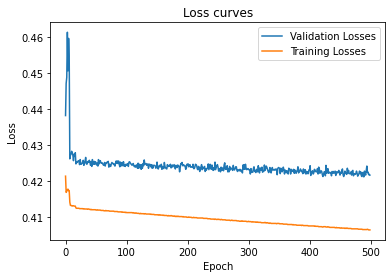

In [0]:
plt.plot(np.arange(len(val_losses)), val_losses, np.arange((len(train_losses))), train_losses)
plt.legend(['Validation Losses', 'Training Losses'])
plt.title('Loss curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')

## RNN

Reference: https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb

In [0]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout=0.2):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell
        
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout=0.2):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        if use_cuda and torch.cuda.is_available():
          self.device = torch.device('cuda')
        else:
          self.device = torch.device('cpu')
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        # outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)

            #place predictions in a tensor holding predictions for each token
            outputs[t] = output

            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

In [0]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.review_text
        # trg = torch.from_numpy(np.flip(src.detach().cpu().numpy(),0).copy()).cuda()
        trg = torch.from_numpy(np.flip(src.numpy(),0).copy())
        # trg = batch.review_text

        optimizer.zero_grad()
        
        output = model(src, trg)
        # print(output.shape)
        # print(trg.shape)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.review_text
            # trg = torch.from_numpy(np.flip(src.detach().cpu().numpy(),0).copy()).cuda()
            trg = torch.from_numpy(np.flip(src.numpy(),0).copy())
            # trg = batch.review_text

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def test(model, iterator):
    model.eval()
    with torch.no_grad():
      for i, batch in enumerate(iterator):
        src = batch.review_text
        trg = torch.from_numpy(np.flip(src.numpy(),0).copy())
        # trg = batch.review_text

        output = model(src, trg, 0)
        output_dim = output.shape[-1]
            
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        return src, trg, output

In [0]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [0]:
import time
import math

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Synthetic Dataset

In [0]:
train_iterator, valid_iterator, test_iterator, VOCAB_SIZE = build_dataset(DRIVE_PATH.joinpath('synthetic.csv'), min_freq=0)

Example
{'review_text': ['that', 'is', 'extremely', 'tasty']}
VOCAB VECTOR SHAPE torch.Size([36, 50])


In [0]:
INPUT_DIM = VOCAB_SIZE
OUTPUT_DIM = VOCAB_SIZE
ENC_EMB_DIM = EMBEDDING_DIM
DEC_EMB_DIM = EMBEDDING_DIM
HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec).to(device)

In [0]:
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(36, 50)
    (rnn): LSTM(50, 256, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(36, 50)
    (rnn): LSTM(50, 256, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=256, out_features=36, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [0]:
PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

In [0]:
N_EPOCHS = 25
CLIP = 1

criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, min_lr=0.00001, factor=0.1)

train_losses, val_losses = [], []

best_valid_loss = float("inf")

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), str(DRIVE_PATH.joinpath('models/rnn_synthetic.pth')))

    scheduler.step(train_loss)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 1s
	Train Loss: 3.571 | Train PPL:  35.561
	 Val. Loss: 3.546 |  Val. PPL:  34.672
Epoch: 02 | Time: 0m 1s
	Train Loss: 3.527 | Train PPL:  34.033
	 Val. Loss: 3.503 |  Val. PPL:  33.214
Epoch: 03 | Time: 0m 1s
	Train Loss: 3.473 | Train PPL:  32.239
	 Val. Loss: 3.442 |  Val. PPL:  31.256
Epoch: 04 | Time: 0m 1s
	Train Loss: 3.392 | Train PPL:  29.711
	 Val. Loss: 3.342 |  Val. PPL:  28.279
Epoch: 05 | Time: 0m 1s
	Train Loss: 3.258 | Train PPL:  26.009
	 Val. Loss: 3.191 |  Val. PPL:  24.321
Epoch: 06 | Time: 0m 1s
	Train Loss: 3.125 | Train PPL:  22.761
	 Val. Loss: 3.112 |  Val. PPL:  22.469
Epoch: 07 | Time: 0m 1s
	Train Loss: 3.083 | Train PPL:  21.814
	 Val. Loss: 3.074 |  Val. PPL:  21.635
Epoch: 08 | Time: 0m 1s
	Train Loss: 3.004 | Train PPL:  20.168
	 Val. Loss: 3.071 |  Val. PPL:  21.561
Epoch: 09 | Time: 0m 1s
	Train Loss: 2.913 | Train PPL:  18.405
	 Val. Loss: 2.962 |  Val. PPL:  19.327
Epoch: 10 | Time: 0m 1s
	Train Loss: 2.746 | Train PPL:  15.577


Text(0, 0.5, 'Loss')

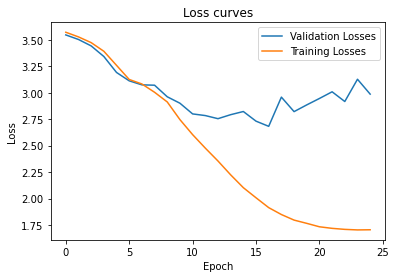

In [0]:
plt.plot(np.arange(len(val_losses)), val_losses, np.arange((len(train_losses))), train_losses)
plt.legend(['Validation Losses', 'Training Losses'])
plt.title('Loss curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')

### Real Dataset

In [0]:
train_iterator, valid_iterator, test_iterator = build_dataset(DRIVE_PATH.joinpath('sentences.csv'))

Example
{'review_text': ['the', 'mozzarella', 'ball', 'was', 'really', 'good']}
VOCAB VECTOR SHAPE torch.Size([4924, 50])


In [0]:
INPUT_DIM = VOCAB_SIZE
OUTPUT_DIM = VOCAB_SIZE
ENC_EMB_DIM = EMBEDDING_DIM
DEC_EMB_DIM = EMBEDDING_DIM
HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec).to(device)

In [0]:
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(4924, 50)
    (rnn): LSTM(50, 256, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(4924, 50)
    (rnn): LSTM(50, 256, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=256, out_features=4924, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [0]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,441,324 trainable parameters


In [0]:
PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

In [0]:
N_EPOCHS = 50
CLIP = 1

criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, min_lr=0.00001, factor=0.1)

train_losses, val_losses = [], []

best_valid_loss = float("inf")

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), str(DRIVE_PATH.joinpath('models/rnnfull.pth')))

    scheduler.step(train_loss)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 113m 18s
	Train Loss: 5.976 | Train PPL: 394.049
	 Val. Loss: 7.463 |  Val. PPL: 1741.996
Epoch: 02 | Time: 113m 38s
	Train Loss: 5.974 | Train PPL: 392.984
	 Val. Loss: 7.097 |  Val. PPL: 1208.679
Epoch: 03 | Time: 113m 3s
	Train Loss: 5.974 | Train PPL: 392.958
	 Val. Loss: 7.371 |  Val. PPL: 1589.321
Epoch: 04 | Time: 112m 51s
	Train Loss: 5.974 | Train PPL: 392.992
	 Val. Loss: 7.209 |  Val. PPL: 1351.455
Epoch: 05 | Time: 113m 25s
	Train Loss: 5.946 | Train PPL: 382.207
	 Val. Loss: 7.309 |  Val. PPL: 1494.259
Epoch: 06 | Time: 113m 49s
	Train Loss: 5.946 | Train PPL: 382.208
	 Val. Loss: 7.269 |  Val. PPL: 1435.823


Text(0, 0.5, 'Loss')

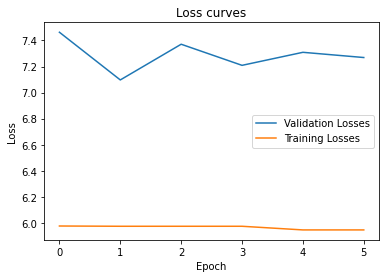

In [0]:
plt.plot(np.arange(len(val_losses)), val_losses, np.arange((len(train_losses))), train_losses)
plt.legend(['Validation Losses', 'Training Losses'])
plt.title('Loss curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')

## ELMO

In [0]:
import tensorflow_hub as hub
import tensorflow as tf

elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

In [0]:
def get_elmo_embedding(x):
  # print(x)
  batches = [x[i:i+batch_size] for i in range(0, len(x), batch_size)]

  all_embeddings = np.zeros(1024)
  count = 0
  with sess.as_default():
    for batch in batches:
      embeddings = elmo(batch, signature="default", as_dict=True)["elmo"]
      embeddings = tf.reduce_mean(embeddings, (0, 1)).eval()
      all_embeddings = all_embeddings + embeddings
      count += 1

  return all_embeddings/count

In [0]:
batch_size = 100

In [0]:
for year in years:
  for n in all_neighbourhoodcounts[year]:  
    print(n)

    if flag == 1:
      emb = get_elmo_embedding(all_neighbourhoodcounts[year][n])
      name = str(DRIVE_PATH.joinpath("elmo/elmo{}_{}".format(year, n.replace("/", ""))))
      np.save(name, emb)

In [0]:
elmo_reviews_2011 = {}
elmo_reviews_2016 = {}

for n in all_neighbourhoodcounts[2011]:  
    name = str(DRIVE_PATH.joinpath("elmo/elmo2011_{}".format(n.replace("/", ""))))+'.npy'
    elmo_reviews_2011[n] = np.load(name)

for n in all_neighbourhoodcounts[2016]:  
    name = str(DRIVE_PATH.joinpath("elmo/elmo2016_{}".format(n.replace("/", ""))))+'.npy'
    elmo_reviews_2016[n] = np.load(name)

reviews_2011 = pd.DataFrame(elmo_reviews_2011).T
reviews_2011.sort_index(inplace=True)
reviews_2011.to_csv(DRIVE_PATH.joinpath('elmo_reviews_2011.csv'))

reviews_2016 = pd.DataFrame(elmo_reviews_2016).T
reviews_2016.sort_index(inplace=True)
reviews_2016.to_csv(DRIVE_PATH.joinpath('elmo_reviews_2016.csv'))